         date  afternoon  morning  night  total_events  morning_ratio  \
0  2025-08-27          8        7      0            15       0.466667   
1  2025-08-29          4        1      0             5       0.200000   
2  2025-08-30          2        1      0             3       0.333333   
3  2025-08-31          2        0      0             2       0.000000   
4  2025-09-01          2        1      0             3       0.333333   

   afternoon_ratio  night_ratio  morning_minutes_proxy  \
0         0.533333          0.0                     35   
1         0.800000          0.0                      5   
2         0.666667          0.0                      5   
3         1.000000          0.0                      0   
4         0.666667          0.0                      5   

   afternoon_minutes_proxy  night_minutes_proxy  total_minutes_proxy  \
0                       40                    0                   75   
1                       20                    0                   25

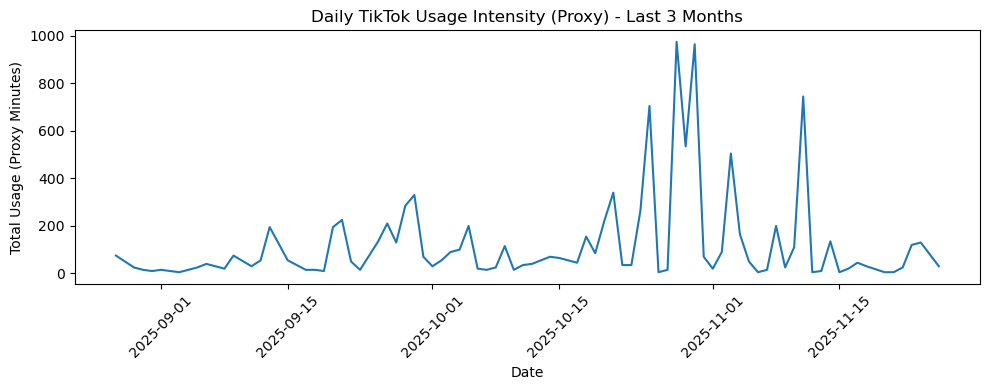

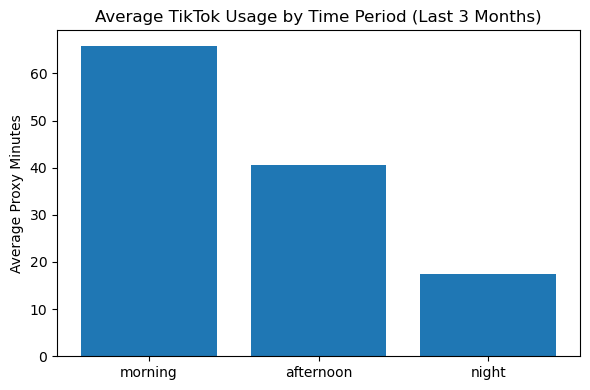

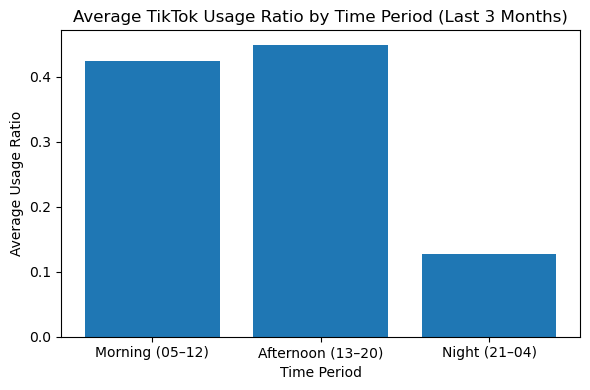

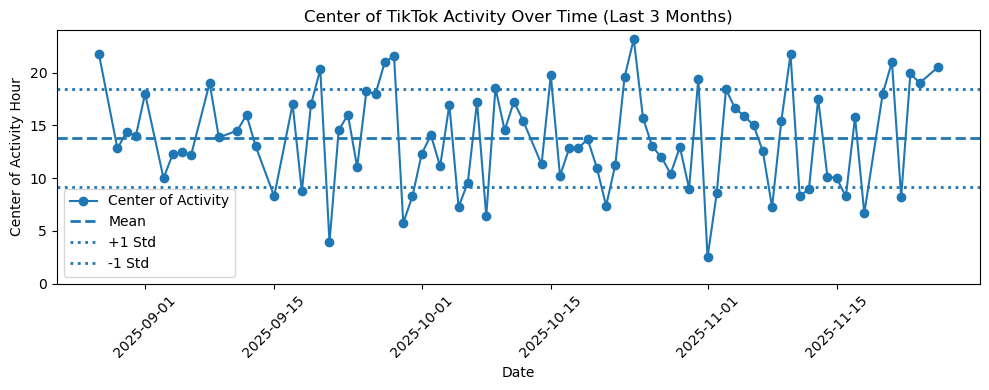

One-way ANOVA results (Morning vs Afternoon vs Night)
F-statistic: 25.876
p-value: 0.0
Paired t-test results (Morning vs Afternoon)
t-statistic: -0.342
p-value: 0.7335
Paired t-test results (Morning vs Night)
t-statistic: 5.805
p-value: 0.0
Independent t-test results (Weekend vs Weekday)
t-statistic: -0.072
p-value: 0.9431
One-sample t-test (Morning Ratio > 0.33)
t-statistic: 2.535
p-value: 0.0066


In [4]:
# @author: beyzacesur

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 1-) IMPORT

json_path = "user_data_tiktok.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

events_list = data["Ads and data"]["Off TikTok Activity"]["OffTikTokActivityDataList"]
df = pd.DataFrame(events_list)


# =============================
# 2) TIME COLUMNS

df["timestamp"] = pd.to_datetime(df["TimeStamp"])
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["day_of_week"] >= 5

# =============================
# 3) LAST 3 MONTHS

son_tarih = df["timestamp"].max()
uc_ay_once = son_tarih - pd.DateOffset(months=3)
df_tiktok = df[df["timestamp"] >= uc_ay_once].copy()

# =============================
# 4) 8 HOUR- PERIODS

def assign_period(hour: int) -> str:
    if 5 <= hour <= 12:
        return "morning"
    elif 13 <= hour <= 20:
        return "afternoon"
    else:
        return "night"

df_tiktok["period"] = df_tiktok["hour"].apply(assign_period)

# =============================
# 5) NUMBER OF EVENTS IN EACH DAY

daily = (
    df_tiktok
    .groupby(["date", "period"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

for col in ["morning", "afternoon", "night"]:
    if col not in daily.columns:
        daily[col] = 0

daily["total_events"] = daily["morning"] + daily["afternoon"] + daily["night"]

denom = daily["total_events"].where(daily["total_events"] != 0, np.nan)
daily["morning_ratio"] = daily["morning"] / denom
daily["afternoon_ratio"] = daily["afternoon"] / denom
daily["night_ratio"] = daily["night"] / denom

# PROXY TIME 

MINUTES_PER_EVENT = 5
daily["morning_minutes_proxy"] = daily["morning"] * MINUTES_PER_EVENT
daily["afternoon_minutes_proxy"] = daily["afternoon"] * MINUTES_PER_EVENT
daily["night_minutes_proxy"] = daily["night"] * MINUTES_PER_EVENT
daily["total_minutes_proxy"] = daily["total_events"] * MINUTES_PER_EVENT

# =============================
# 6) CENTER OF ACTIVITY HOUR

def circular_mean_hour(hours: np.ndarray) -> float:
    if len(hours) == 0:
        return np.nan
    radians = np.deg2rad(hours * 15)
    sin_sum = np.sin(radians).sum()
    cos_sum = np.cos(radians).sum()
    mean_angle = np.arctan2(sin_sum, cos_sum)
    if mean_angle < 0:
        mean_angle += 2 * np.pi
    return np.rad2deg(mean_angle) / 15.0

center_hours = (
    df_tiktok
    .groupby("date")["hour"]
    .apply(lambda x: circular_mean_hour(x.values))
    .reset_index(name="center_of_activity_hour")
)

weekend_info = (
    df_tiktok
    .groupby("date")["is_weekend"]
    .max()
    .reset_index()
)

daily_features = (
    daily
    .merge(center_hours, on="date", how="left")
    .merge(weekend_info, on="date", how="left")
)

print(daily_features.head())
print("\nSon 3 ay tarih aralığı:",
      daily_features['date'].min(), "→", daily_features['date'].max())

# =============================
# 7) EDA GRAPHS


# 7.1 TOTAL DAILY USAGE
plt.figure(figsize=(10, 4))
plt.plot(daily_features["date"], daily_features["total_minutes_proxy"])
plt.xlabel("Date")
plt.ylabel("Total Usage (Proxy Minutes)")
plt.title("Daily TikTok Usage Intensity (Proxy) - Last 3 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7.2 AVERAGE USAGE BY PERIODS
period_means = {
    "morning": daily_features["morning_minutes_proxy"].mean(),
    "afternoon": daily_features["afternoon_minutes_proxy"].mean(),
    "night": daily_features["night_minutes_proxy"].mean(),
}

plt.figure(figsize=(6, 4))
plt.bar(period_means.keys(), period_means.values())
plt.ylabel("Average Proxy Minutes")
plt.title("Average TikTok Usage by Time Period (Last 3 Months)")
plt.tight_layout()
plt.show()



# 7.3 AVERAGE RATIO FOR EACH PERIOD
period_ratios = {
    "Morning (05–12)": daily_features["morning_ratio"].mean(),
    "Afternoon (13–20)": daily_features["afternoon_ratio"].mean(),
    "Night (21–04)": daily_features["night_ratio"].mean(),
}

plt.figure(figsize=(6, 4))
plt.bar(period_ratios.keys(), period_ratios.values())
plt.ylabel("Average Usage Ratio")
plt.xlabel("Time Period")
plt.title("Average TikTok Usage Ratio by Time Period (Last 3 Months)")
plt.tight_layout()
plt.show()


# 7.4 CENTER OF ACTIVITY- OUTLIER
mean_hour = daily_features["center_of_activity_hour"].mean()
std_hour = daily_features["center_of_activity_hour"].std()
upper_bound = mean_hour + std_hour
lower_bound = mean_hour - std_hour

plt.figure(figsize=(10, 4))
plt.plot(
    daily_features["date"],
    daily_features["center_of_activity_hour"],
    marker='o',
    label="Center of Activity"
)
plt.axhline(mean_hour, linestyle="--", linewidth=2, label="Mean")
plt.axhline(upper_bound, linestyle=":", linewidth=2, label="+1 Std")
plt.axhline(lower_bound, linestyle=":", linewidth=2, label="-1 Std")

plt.xlabel("Date")
plt.ylabel("Center of Activity Hour")
plt.title("Center of TikTok Activity Over Time (Last 3 Months)")
plt.ylim(0, 24)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



# 8-) HYPOTHESIS TESTING

# 8.1 One-way ANOVA: Comparison of Usage Ratios Across Time Periods

from scipy import stats

morning = daily_features["morning_ratio"]
afternoon = daily_features["afternoon_ratio"]
night = daily_features["night_ratio"]

F_stat, p_value = stats.f_oneway(
    morning.dropna(),
    afternoon.dropna(),
    night.dropna()
)

print("One-way ANOVA results (Morning vs Afternoon vs Night)")
print("F-statistic:", round(F_stat, 3))
print("p-value:", round(p_value, 4))





# 8.2 Paired t-test: Comparison of Morning and Afternoon Usage Ratios

from scipy import stats

# Morning ve Afternoon ratio değerleri (aynı günler için)
morning_ratio = daily_features["morning_ratio"]
afternoon_ratio = daily_features["afternoon_ratio"]

# Paired samples t-test
t_stat, p_value = stats.ttest_rel(
    morning_ratio,
    afternoon_ratio,
    nan_policy="omit"
)

print("Paired t-test results (Morning vs Afternoon)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))

#8.3 Paired t-test: Comparison of Morning and Night Usage Ratios

from scipy import stats

# Morning ve Afternoon ratio değerleri (aynı günler için)
morning_ratio = daily_features["morning_ratio"]
night_ratio = daily_features["night_ratio"]

# Paired samples t-test
t_stat, p_value = stats.ttest_rel(
    morning_ratio,
    night_ratio,
    nan_policy="omit"
)

print("Paired t-test results (Morning vs Night)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))





# 8.4 Independent t-test: Comparison of Weekend and Weekday Usage (Proxy Minutes)

from scipy import stats

weekend_usage = daily_features.loc[
    daily_features["is_weekend"] == True,
    "total_minutes_proxy"
]

weekday_usage = daily_features.loc[
    daily_features["is_weekend"] == False,
    "total_minutes_proxy"
]


t_stat, p_value = stats.ttest_ind(
    weekend_usage,
    weekday_usage,
    nan_policy="omit",
    equal_var=False
)

print("Independent t-test results (Weekend vs Weekday)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))

# 8.5 One-sample t-test: Testing Whether Morning Usage Ratio Exceeds an Equal-Share Baseline

from scipy import stats

morning_ratio = daily_features["morning_ratio"]

# One-sample t-test (greater than 0.5)
t_stat, p_value = stats.ttest_1samp(
    morning_ratio,
    popmean=0.33,
    alternative="greater",
    nan_policy="omit"
)

print("One-sample t-test (Morning Ratio > 0.33)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))















